# Vehicle Sales Profitability Analysis

This notebook analyzes vehicle sales data loaded from a CSV file to uncover key profitability insights by vehicle make.

We compute summary metrics such as total sales, total profit, average profit, and profit margin percentages.

Using these metrics, we visualize which vehicle makes are the most profitable and have the highest profit margins. These insights can help guide business decisions around inventory, marketing, and sales strategies.

The analysis leverages Python libraries such as pandas for data manipulation and seaborn/matplotlib for visualization.

In [79]:
import pandas as pd

csv_path = 'sample_vehicle_sales.csv'

print("📄 Loading demo data from CSV...")
try:
    df = pd.read_csv(csv_path)
    print(f"✅ Data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
    display(df.head())
except FileNotFoundError:
    print(f"❌ Error: {csv_path} not found. Please upload the CSV file.")

📄 Loading demo data from CSV...
✅ Data loaded: 99,999 rows × 18 columns


,YEAR,VIN,CONDITION,MMR,SELLINGPRICE,SALEDATE,MAKE,MODEL,TRIM,BODY,COLOR,INTERIOR,TRANSMISSION,STATE,SELLER,SALE_DATE,PROFIT,ODOMETER
0,2005,1n4al11d95c162224,22.0,625,900,2015-01-27T02:00:00-08:00,Nissan,Altima,2.5 S,Sedan,beige,beige,unknown,QC,Garage Michel Savary,00:00.0,275,249762
1,2005,5n1aa08a35n718212,29.0,5600,5700,2015-01-07T14:30:00-08:00,Nissan,Armada,SE,SUV,unknown,black,unknown,NC,Hendrick Lexus,30:00.0,100,154265
2,2005,jn8az08w05w400376,34.0,5300,7200,2015-01-15T01:05:00-08:00,Nissan,Murano,SL,SUV,white,gray,automatic,VA,Dt Credit Corporation,05:00.0,1900,114553
3,2005,5n1ar18u55c717714,29.0,4150,5400,2015-01-07T12:30:00-08:00,Nissan,Pathfinder,LE,SUV,blue,beige,automatic,CA,Hoehn Honda,30:00.0,1250,159240
4,2005,5n1bv28u35n119177,19.0,1700,1800,2015-01-07T10:30:00-08:00,Nissan,Quest,3.5 SE,Minivan,blue,gray,automatic,MN,Royal Credit Union,30:00.0,100,192336


In [80]:
def summary_metrics(df: pd.DataFrame):
    # Basic aggregations
    total_sales = len(df)
    total_profit = df["PROFIT"].sum()
    avg_profit = df["PROFIT"].mean()
    avg_mmr = df["MMR"].mean()
    avg_selling_price = df["SELLINGPRICE"].mean()

    # Average profit margin
    df["profit_margin"] = (df["PROFIT"] / df["SELLINGPRICE"]) * 100
    avg_profit_margin = df["profit_margin"].mean()

    median_odometer = df["ODOMETER"].median()
    unique_makes = df["MAKE"].nunique()
    unique_models = df["MODEL"].nunique()

    # Most common body type
    most_common_body = df["BODY"].mode().iloc[0] if not df["BODY"].mode().empty else "N/A"

    # Safely parse SALEDATE
    df["SALEDATE_PARSED"] = pd.to_datetime(df["SALEDATE"], errors='coerce', utc=True)

    # Drop invalid dates
    n_invalid = df["SALEDATE_PARSED"].isna().sum()
    if n_invalid > 0:
        print(f"⚠️ Warning: {n_invalid} rows had invalid SALEDATE and were ignored for vehicle age.")

    df_valid = df.dropna(subset=["SALEDATE_PARSED"]).copy()
    df_valid["SALE_YEAR"] = df_valid["SALEDATE_PARSED"].dt.year

    # Average vehicle age
    avg_vehicle_age = (df_valid["SALE_YEAR"] - df_valid["YEAR"]).mean()

    # Build the metrics DataFrame
    metrics_df = pd.DataFrame([
        ["Total Sales", total_sales],
        ["Total Profit", total_profit],
        ["Average Profit", avg_profit],
        ["Average MMR", avg_mmr],
        ["Average Selling Price", avg_selling_price],
        ["Average Profit Margin (%)", avg_profit_margin],
        ["Median Odometer", median_odometer],
        ["Unique Makes Sold", unique_makes],
        ["Unique Models Sold", unique_models],
        ["Most Common Body Type", most_common_body],
        ["Average Vehicle Age at Sale", avg_vehicle_age]
    ], columns=["Metric", "Value"])

    # Formatting functions
    def fmt_currency(x): return f"${x:,.2f}"
    def fmt_int(x): return f"{int(round(x)):,}"
    def fmt_float(x): return f"{x:,.2f}"

    # Format integers
    int_metrics = ["Total Sales", "Median Odometer", "Unique Makes Sold", "Unique Models Sold"]
    metrics_df.loc[metrics_df['Metric'].isin(int_metrics), 'Value'] = \
        metrics_df.loc[metrics_df['Metric'].isin(int_metrics), 'Value'].apply(fmt_int)

    # Format currency
    currency_metrics = ["Total Profit", "Average Profit", "Average MMR", "Average Selling Price"]
    metrics_df.loc[metrics_df['Metric'].isin(currency_metrics), 'Value'] = \
        metrics_df.loc[metrics_df['Metric'].isin(currency_metrics), 'Value'].apply(fmt_currency)

    # Format percentages and floats
    metrics_df.loc[metrics_df['Metric'] == "Average Profit Margin (%)", 'Value'] = \
        metrics_df.loc[metrics_df['Metric'] == "Average Profit Margin (%)", 'Value'].apply(fmt_float)
    metrics_df.loc[metrics_df['Metric'] == "Average Vehicle Age at Sale", 'Value'] = \
        metrics_df.loc[metrics_df['Metric'] == "Average Vehicle Age at Sale", 'Value'].apply(fmt_float)

    return metrics_df

In [81]:
def profitability_by_make(df: pd.DataFrame):
    # Group by MAKE and calculate the metrics
    profit_stats = (
        df.groupby("MAKE")
          .agg(
              TOTAL_PROFIT=pd.NamedAgg(column="PROFIT", aggfunc="sum"),
              AVG_PROFIT=pd.NamedAgg(column="PROFIT", aggfunc="mean"),
              AVG_PROFIT_MARGIN_PCT=pd.NamedAgg(
                  column="PROFIT",
                  aggfunc=lambda x: ((x / df.loc[x.index, "SELLINGPRICE"]) * 100).mean()
              ),
              NUM_SALES=pd.NamedAgg(column="PROFIT", aggfunc="count")
          )
          .reset_index()
          .sort_values(by="TOTAL_PROFIT", ascending=False)
          .head(10)
    )

    # Format the output
    profit_stats["TOTAL_PROFIT"] = profit_stats["TOTAL_PROFIT"].apply(lambda x: f"${x:,.2f}")
    profit_stats["AVG_PROFIT"] = profit_stats["AVG_PROFIT"].apply(lambda x: f"${x:,.2f}")
    profit_stats["AVG_PROFIT_MARGIN_PCT"] = profit_stats["AVG_PROFIT_MARGIN_PCT"].apply(lambda x: f"{x:.2f}%")
    profit_stats["NUM_SALES"] = profit_stats["NUM_SALES"].apply(lambda x: f"{x:,}")

    # Rename columns for readability
    profit_stats.rename(columns={
        "MAKE": "Make",
        "TOTAL_PROFIT": "Total Profit",
        "AVG_PROFIT": "Average Profit",
        "AVG_PROFIT_MARGIN_PCT": "Average Profit Margin (%)",
        "NUM_SALES": "Number of Sales"
    }, inplace=True)

    return profit_stats

In [82]:
df = pd.read_csv(csv_path)
summary_df = summary_metrics(df)
summary_df

,Metric,Value
0,Total Sales,"99,999"
1,Total Profit,"$95,281,918.00"
2,Average Profit,$952.83
3,Average MMR,"$13,878.38"
4,Average Selling Price,"$14,831.20"
5,Average Profit Margin (%),8.84
6,Median Odometer,"50,094"
7,Unique Makes Sold,85
8,Unique Models Sold,811
9,Most Common Body Type,Sedan


In [83]:
df = pd.read_csv(csv_path)
profit_stats_df = profitability_by_make(df)
profit_stats_df

,Make,Total Profit,Average Profit,Average Profit Margin (%),Number of Sales
14,Ford,"$16,200,705.00",$990.02,8.16%,"16,364"
7,Chevrolet,"$9,873,727.00",$919.08,9.13%,"10,743"
34,Nissan,"$9,129,943.00",$944.35,8.39%,"9,668"
47,Toyota,"$6,006,395.00",$846.09,8.10%,"7,099"
3,BMW,"$5,023,891.00","$1,362.97",7.92%,"3,686"
10,Dodge,"$4,590,166.00",$848.46,9.01%,"5,410"
18,Honda,"$4,457,625.00",$858.89,9.91%,"5,190"
31,Mercedes-Benz,"$3,309,584.00","$1,158.01",7.54%,"2,858"
20,Infiniti,"$3,280,282.00","$1,165.70",6.36%,"2,814"
23,Jeep,"$2,956,238.00","$1,040.20",8.43%,"2,842"


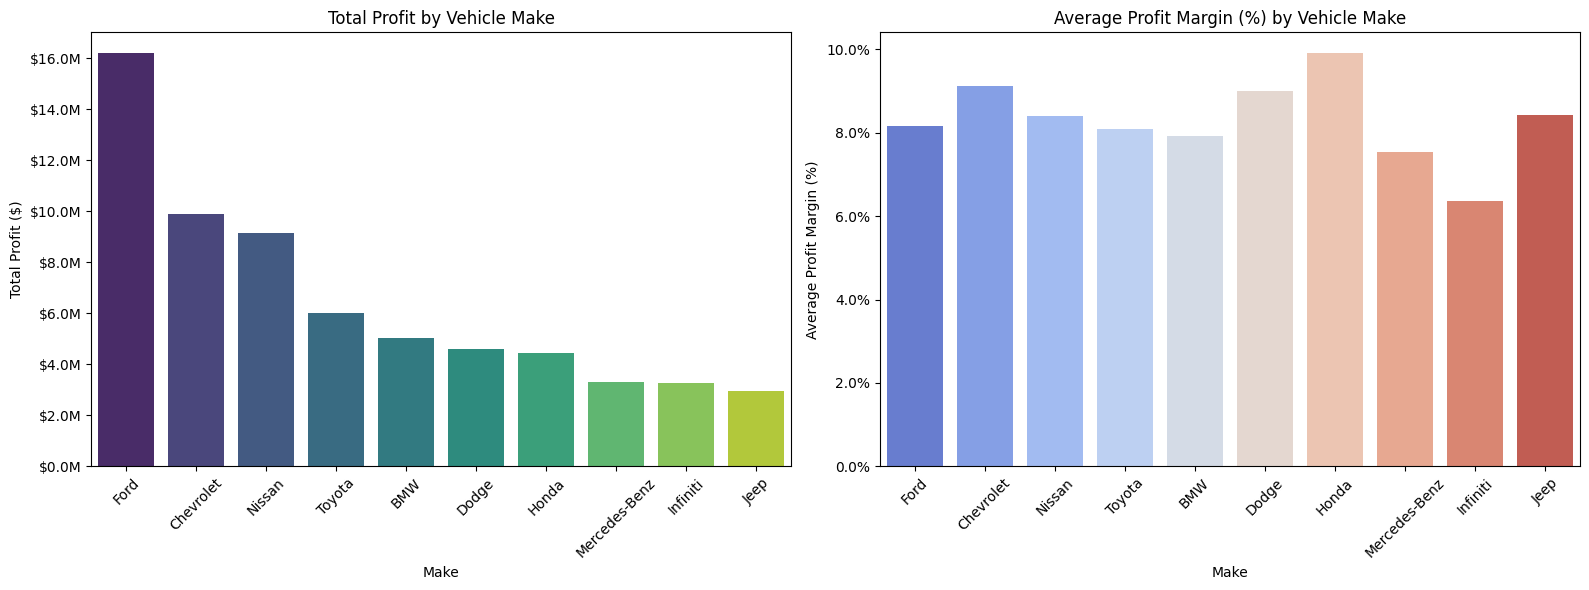

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Ensure numeric columns exist
if "Total Profit Numeric" not in profit_stats_df.columns:
    profit_stats_df["Total Profit Numeric"] = (
        profit_stats_df["Total Profit"]
        .str.replace('[\$,]', '', regex=True)
        .astype(float)
    )

if "Average Profit Margin Numeric" not in profit_stats_df.columns:
    profit_stats_df["Average Profit Margin Numeric"] = (
        profit_stats_df["Average Profit Margin (%)"]
        .str.replace('%', '', regex=True)
        .astype(float)
    )

# Set up figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# --- Plot 1: Total Profit ---
sns.barplot(
    data=profit_stats_df,
    x='Make',
    y='Total Profit Numeric',
    hue='Make',
    palette='viridis',
    legend=False,
    ax=axes[0]
)

axes[0].set_title('Total Profit by Vehicle Make')
axes[0].set_ylabel('Total Profit ($)')
axes[0].set_xlabel('Make')
axes[0].tick_params(axis='x', rotation=45)
axes[0].yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M')
)

# --- Plot 2: Average Profit Margin (%) ---
sns.barplot(
    data=profit_stats_df,
    x='Make',
    y='Average Profit Margin Numeric',
    hue='Make',
    palette='coolwarm',
    legend=False,
    ax=axes[1]
)

axes[1].set_title('Average Profit Margin (%) by Vehicle Make')
axes[1].set_ylabel('Average Profit Margin (%)')
axes[1].set_xlabel('Make')
axes[1].tick_params(axis='x', rotation=45)
axes[1].yaxis.set_major_formatter(
    mtick.PercentFormatter()
)

plt.tight_layout()
plt.show()

# Conclusion

This analysis of vehicle sales data provided valuable insights into profitability by vehicle make.  
We identified the top-performing makes in terms of total profit, average profit, and profit margins.  
The visualizations highlighted how profit is distributed across different makes, revealing clear leaders in profitability.

These findings can inform strategic decisions about which vehicle makes to prioritize in inventory and marketing efforts.

By using Python and open-source tools, we created a reproducible and flexible analysis that can be adapted to other datasets or extended with additional metrics and visualizations.